# The Rise-Contact involution on Interval-posets

The notebook shows some implementation related to the following paper:

[1] Viviane Pons. The Rise-Contact involution on Tamari Intervals



In [1]:
# utils: a function to show latex printed objects in the notebook
# useful to show objects on a Jupyter notebook
# on a local Sage instal, just use view(objects)
from sage.misc.latex import _Latex_prefs
from sage.misc.latex import png
import os
from IPython.display import Image
def viewLatex(objects):
    engine = _Latex_prefs._option["engine"]
    file_name = tmp_filename() + ".png"
    png(objects, file_name, debug = False, engine = engine)
    return Image(filename = file_name)

## Statistics

First let us see how to get the different statistics on Tamari intervals referenced in the paper.

The *number of contacts* and *initial rises* are already implemented for Dyck Paths.

In [2]:
dw = DyckWord([1,1,0,1,1,0,0,0,1,1,0,1,1,0,1,1,0,0,0,0])

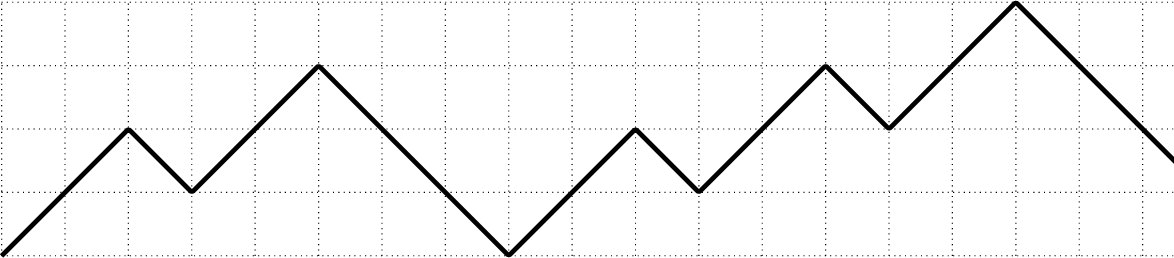

In [3]:
viewLatex(dw)

In [4]:
dw.number_of_touch_points()

2

In [5]:
dw.number_of_initial_rises()

2

In [16]:
def contact_vector(dw):
    x = 0
    y = 0
    vector = [dw.number_of_touch_points()]
    for i,step in enumerate(dw):
        if step == 1:
            y += 1
            d = y - x
            c = 0
            xx = x
            yy = y
            for k in xrange(i+1,len(dw)):
                dd = yy - xx
                if dd == d:
                    c+=1
                elif dd < d:
                    break
                xx, yy = (xx+1, yy) if dw[k] == 0 else (xx, yy+1)
            c -= 1
            vector.append(c)
            
        else:
            x += 1
    return vector[:-1]

In [17]:
contact_vector(dw)

[2, 2, 0, 1, 0, 2, 0, 2, 0, 1]

In [18]:
def rise_vector(dw):
    vector = []
    r = 0
    for step in dw:
        if step == 0:
            vector.append(r)
            r = 0
        else:
            r+=1
    return vector

In [19]:
rise_vector(dw)

[2, 2, 0, 0, 2, 2, 2, 0, 0, 0]

We represent the contact monomial and rise monomial as partitions: each occurrence of $i$ in the list represents an occurrence of $x_i$ (resp. $y_i$) in the monomial.

In [20]:
def contact_monomial(dw):
    v = contact_vector(dw)
    v.sort()
    v.reverse()
    return v

In [21]:
def rise_monomial(dw):
    v = rise_vector(dw)
    v.sort()
    v.reverse()
    return v

In [22]:
contact_monomial(dw)

[2, 2, 2, 2, 1, 1, 0, 0, 0, 0]

In [23]:
rise_monomial(dw)

[2, 2, 2, 2, 2, 0, 0, 0, 0, 0]

Here are the basic functions to get those statistics on interval-posets.

In [26]:
def contacts_interval(tip):
    return tip.lower_dyck_word().number_of_touch_points()

def rises_interval(tip):
    return tip.upper_dyck_word().number_of_initial_rises()

def contact_vector_interval(tip):
    return contact_vector(tip.lower_dyck_word())

def rise_vector_interval(tip):
    return rise_vector(tip.upper_dyck_word())

def contact_monomial_interval(tip):
    return contact_monomial(tip.lower_dyck_word())

def rise_monomial_interval(tip):
    return rise_monomial(tip.upper_dyck_word())

In [27]:
# The interval poset of Fig. 3
tip = TamariIntervalPoset(10, [(2,5), (3,4), (4,5), (6,7), (8,10), (9,10), (3,2), (4,2), (6,5), (7,5), (8,5), (10,5), (9,8)])

In [28]:
tip

The Tamari interval of size 10 induced by relations [(2, 5), (3, 4), (4, 5), (6, 7), (8, 10), (9, 10), (10, 5), (9, 8), (8, 5), (7, 5), (6, 5), (4, 2), (3, 2)]

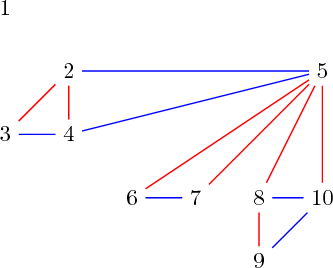

In [29]:
viewLatex(tip)

In [30]:
contacts_interval(tip)

3

In [31]:
rises_interval(tip)

3

In [32]:
contact_vector_interval(tip)

[3, 0, 2, 0, 0, 4, 0, 0, 1, 0]

In [33]:
rise_vector_interval(tip)

[3, 1, 0, 2, 3, 0, 1, 0, 0, 0]

In [35]:
contact_monomial_interval(tip)

[4, 3, 2, 1, 0, 0, 0, 0, 0, 0]

In [36]:
rise_monomial_interval(tip)

[3, 3, 2, 1, 1, 0, 0, 0, 0, 0]

The paper also defined the DC and IC vectors.

In [44]:
def dc(tip):
    L = [len(tip.decreasing_children(i)) for i in tip]
    return [len(tip.decreasing_roots())] + L[:-1]

def ic(tip):
    L = [len(tip.increasing_children(i)) for i in tip]
    L.reverse()
    return [len(tip.increasing_roots())] + L[:-1]

In [45]:
dc(tip)

[3, 0, 2, 0, 0, 4, 0, 0, 1, 0]

In [46]:
ic(tip)

[4, 2, 0, 0, 1, 0, 2, 1, 0, 0]

You can check that DC is similar to the contact vector.

In [47]:
all(dc(v) == contact_vector_interval(v) for v in TamariIntervalPosets(4))

True

The *distance* statistic can be computed directly on interval-posets by computing the number of Tamari inversions.

In [49]:
tip.number_of_tamari_inversions()

4

## Involutions

### Grafting Trees

The following functions gives the grafting-tree of an interval-poset and the inverse construction.

In [54]:
def decompose(tip):
    """
    Decompose an interval-poset into a triplet (left, right, r)
    
    Input:
        - tip, an interval poset
        
    Output: a triplet (left, right, r) where left and right are interval posets and r 
    is the parameter of the composition.
    """
    n = tip.size()
    if n == 0:
        return None
    root = tip.increasing_roots()[-1]
    r = len(tip.decreasing_children(root))
    left = tip.sub_poset(1,root)
    right = tip.sub_poset(root+1,tip.size()+1)
    return left, right, r

def recompose(left, right, r):
    """
    Recompose an interval-poset from a triplet (left, right, r)
    
    Input:
        - left, an interval-poset
        - right, an interval-poset
        - r, the parameter of the recomposition
        
    Output: an interval-poset
    """
    root = left.size() + 1
    rel = left.poset().cover_relations()
    rel.extend((i,root) for i in left)
    rel.extend((root+a,root+b) for a,b in right.poset().cover_relations())
    decroot = right.decreasing_roots()[:r]
    rel.extend((root+i,root) for i in decroot)
    return TamariIntervalPoset(left.size()+right.size()+1,rel)
    
def grafting_tree(tip):
    n = tip.size()
    if n == 0:
        return LabelledBinaryTree(None)
    left, right, r = decompose(tip)
    return LabelledBinaryTree([grafting_tree(left), grafting_tree(right)], label = r)

def interval_from_grafting_tree(tree):
    if tree.is_empty():
        return TamariIntervalPoset(0,[])
    r = tree.label()
    left = interval_from_grafting_tree(tree[0])
    right = interval_from_grafting_tree(tree[1])
    return recompose(left, right, r)

Here is the computation of the example of Fig. 19.

In [56]:
tip = TamariIntervalPoset(8, [(1,2), (2,4), (3,4), (6,7), (3,2), (5,4), (6,4), (8,7)])

In [57]:
decompose(tip)

(The Tamari interval of size 3 induced by relations [(1, 2), (3, 2)],
 The Tamari interval of size 4 induced by relations [(2, 3), (4, 3)],
 2)

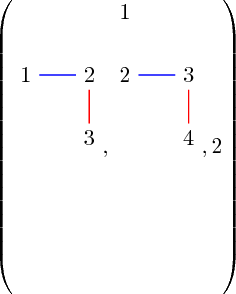

In [59]:
viewLatex(decompose(tip))

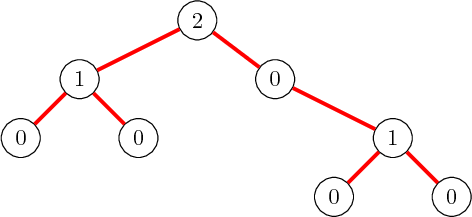

In [60]:
viewLatex(grafting_tree(tip))

In [61]:
t = grafting_tree(tip)
t

2[1[0[., .], 0[., .]], 0[., 1[0[., .], 0[., .]]]]

In [63]:
tip == interval_from_grafting_tree(t)

True

### Left branch involution

This allows us to implement very easily the left branch involution.

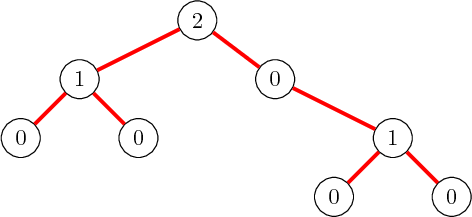

In [64]:
viewLatex(t)

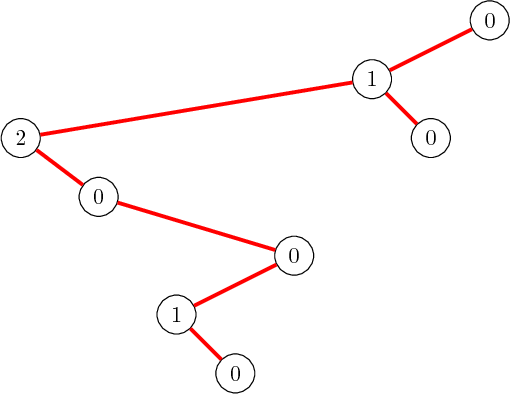

In [65]:
viewLatex(t.left_border_symmetry())

In [66]:
def left_branch_involution(tip):
    return interval_from_grafting_tree(grafting_tree(tip).left_border_symmetry())

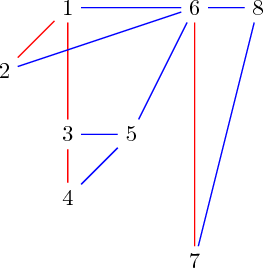

In [67]:
viewLatex(left_branch_involution(tip))

You can check that the left branch involution exchanges the IC vector and rise vector while keeping the contact monomial and distance.

In [68]:
def check_left_branch_involution_statistics(tip):
    image = left_branch_involution(tip)
    return rise_vector_interval(image) == ic(tip) and contact_monomial_interval(image) == contact_monomial_interval(tip) and image.number_of_tamari_inversions() == tip.number_of_tamari_inversions()

In [69]:
check_left_branch_involution_statistics(tip)

True

In [70]:
all(check_left_branch_involution_statistics(v) for v in TamariIntervalPosets(4))

True